In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3
import json

In [2]:
# taken from Peter and Lynne's original notebooks
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# get just the first year of observations

In [3]:
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

In [4]:
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<366]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

In [5]:
# set nside for analysis metric (use higher resolution when removing no-template images later)
nside = 32
s = maf.HealpixSlicer(nside=nside)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [6]:
# from lynne's notebook, counts the number of visits that have templates
# assuming they are made as soon as enough images are available

In [7]:
# Metric in development

class TemplateTime(maf.BaseMetric):
    """Find the time at which we expect to hit incremental template availability.
    
    Note that there are some complications to real template generation that make this an 
    approximation and not an exact answer -- one aspect is that templates are generated in 
    `patches` and not per pixel. However, it may be possible to generate parts of these patches
    at about 5arcsecond scales, which implies running with a healpix slicer at nside=512 or 1024. 
    
    Parameters
    ----------
    n_visits : `int`, opt
        Number of qualified visits required for incremental template generation. 
        Default 3. 
    seeing_range : `float`, opt
        Range of seeing to allow in the qualified images. 
    m5_range : `float`, opt
        Range of m5 values to allow in the qualified images. Stand in for `weight` in template.
    seeingCol : `str`, opt
        Name of the seeing column to use.
    m5Col : `str`, opt
        Name of the five sigma depth columns.
    nightCol : `str`, opt
        Name of the column describing the night of the visit.
    """
    
    def __init__(self, n_visits=3, seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 nightCol = 'night', **kwargs):
        self.n_visits = n_visits
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.nightCol = nightCol
        if 'metricName' in kwargs:
            self.metricName = kwargs['metricName']
            del kwargs['metricName']
        else:
            self.metricName = 'TemplateTime'
        super().__init__(col=[self.seeingCol, self.m5Col, self.nightCol], 
                         metricName=self.metricName, units="days", **kwargs)

    def run(self, dataSlice, slicePoint=None):
        # Bail if not enough visits at all
        if len(dataSlice) < self.n_visits:
            return self.badval
        
        # Check that the visits are sorted in night
        dataSlice.sort(order=self.nightCol)
        
        # Find the best seeing in the first few images
        bench_seeing = np.min(dataSlice[self.seeingCol][0:self.n_visits+1])
        bench_m5 = np.max(dataSlice[self.m5Col][0:self.n_visits+1])
        
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False)
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)

        both = np.where(seeing_ok & m5_ok)[0]
        if len(both) < self.n_visits:
            return self.badval
            
        idx_template = both[self.n_visits - 1]
        
        n_template = dataSlice[self.nightCol][idx_template]
        d_n = n_template - dataSlice[self.nightCol][0]

        return [n_template, d_n, idx_template + 1]
    
    def reduceNight(self, metricVal):
        return metricVal[0]
    
    def reduceDeltaNight(self, metricVal):
        return metricVal[1]
    
    def reduceNVis(self, metricVal):
        return metricVal[2]

In [8]:
opsim_fname = year1_fname
opsim_fname

'first_year_baseline_v3.0_10yrs.db'

In [9]:
opsdb = maf.OpsimDatabase(opsim_fname)
runName = os.path.split(opsdb)[-1].replace('.db', '')

In [10]:
bdict = {}
for f in 'ugrizy':
    m = TemplateTime(metricName=f'Template {f}')
    constraint = f'filter == "{f}"'
    bdict[f] = maf.MetricBundle(m, s, constraint, runName=runName)
    
g = maf.MetricBundleGroup(bdict, opsdb, 'temp')
g.runAll()

Querying table None with constraint filter == "i" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'fieldRA', 'fieldDec', 'night', 'rotSkyPos']
Found 52835 visits
Running:  ['i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "z" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'fieldRA', 'fieldDec', 'night', 'rotSkyPos']
Found 39733 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "r" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'fieldRA', 'fieldDec', 'night', 'rotSkyPos']
Found 49269 visits
Running:  ['r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "u" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'fieldRA', 'fieldDec', 'night', 'rotSkyPos']
Found 10136 visits
Running:  ['u']
Completed me

In [11]:
bdict.keys()


dict_keys(['u', 'g', 'r', 'i', 'z', 'y', 'Template i_DeltaNight', 'Template i_NVis', 'Template i_Night', 'Template z_DeltaNight', 'Template z_NVis', 'Template z_Night', 'Template r_DeltaNight', 'Template r_NVis', 'Template r_Night', 'Template u_DeltaNight', 'Template u_NVis', 'Template u_Night', 'Template y_DeltaNight', 'Template y_NVis', 'Template y_Night', 'Template g_DeltaNight', 'Template g_NVis', 'Template g_Night'])

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


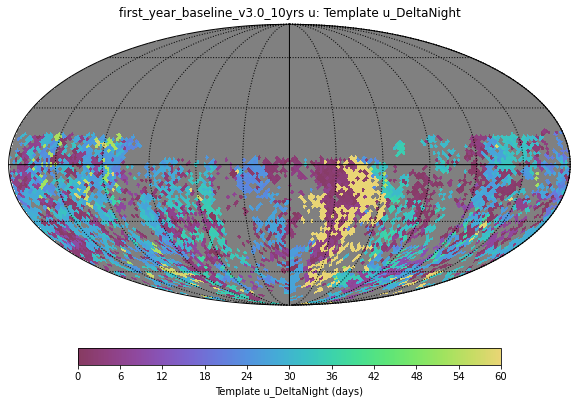

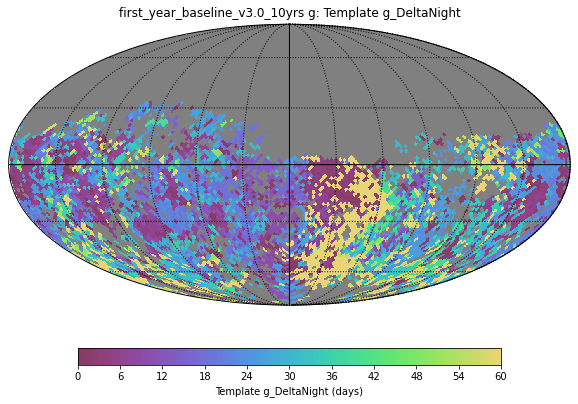

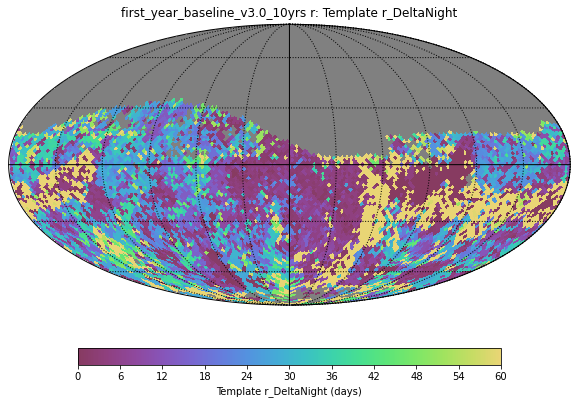

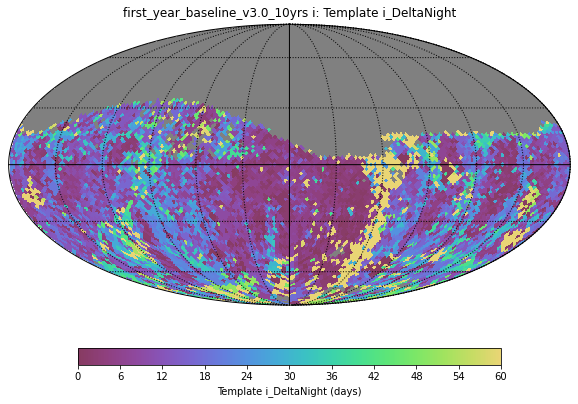

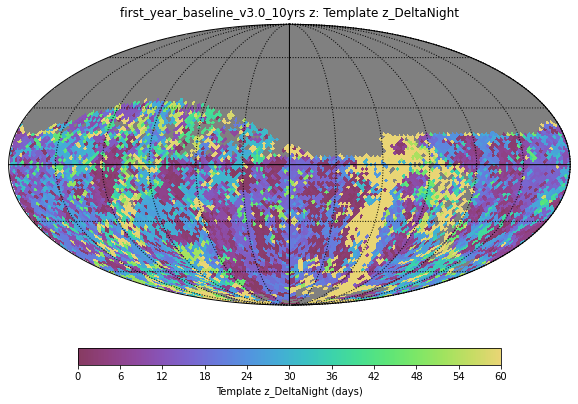

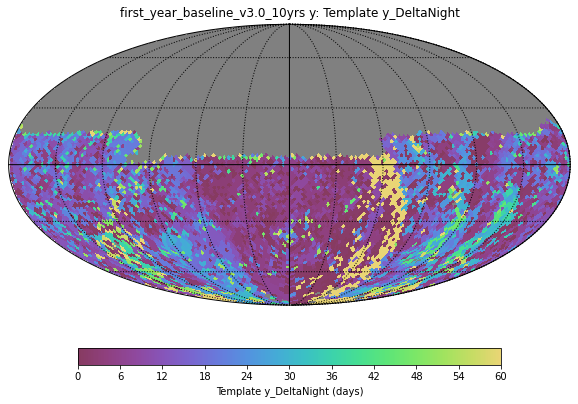

In [12]:

ph = maf.PlotHandler(outDir='temp', thumbnail=False)

for f in 'ugrizy':
    k = f'Template {f}_DeltaNight'
    ph.setMetricBundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'colorMin': 0, 'colorMax': 60}
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts=plotDict)

In [13]:

nights = np.arange(0, 3650, 1)
pixarea = hp.nside2pixarea(nside, degrees=True)
area_over_time = {}
area_since_first = {}
for f in 'ugrizy':
    k = f'Template {f}_Night'
    counts, bins = np.histogram(bdict[k].metricValues.compressed(), bins=nights)
    area_over_time[f] = counts.cumsum() * pixarea 
    k = f'Template {f}_DeltaNight'
    counts, bins = np.histogram(bdict[k].metricValues.compressed(), bins=nights)
    area_since_first[f] = counts.cumsum() * pixarea 

In [14]:

# Count up area in footprint, for reference (varies by filter)
footprint_area = {}
for f in 'ugrizy':
    k = f'Template {f}_Night'
    footprint_area[f] = len(bdict[k].metricValues.compressed()) * pixarea

{'u': 14788.354028620759, 'g': 20344.477959918684, 'r': 26649.25182274497, 'i': 26978.254931667747, 'z': 26212.81912723516, 'y': 24564.44640804043}


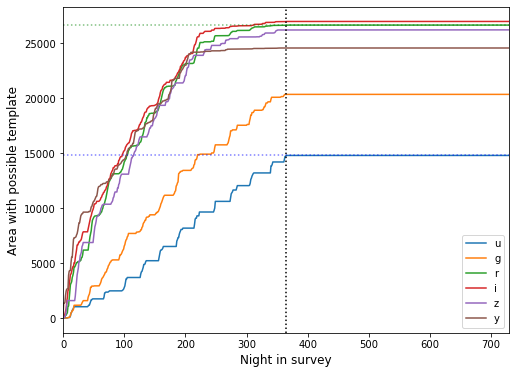

In [15]:

plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    plt.plot(nights[:-1], area_over_time[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlabel('Night in survey', fontsize='large')
plt.ylabel('Area with possible template', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
plt.axhline(footprint_area['u'], color='b', linestyle=':', alpha=0.5)
plt.axhline(footprint_area['r'], color='g', linestyle=':', alpha=0.5)
print(footprint_area)

{'u': 14788.354028620759, 'g': 20344.477959918684, 'r': 26649.25182274497, 'i': 26978.254931667747, 'z': 26212.81912723516, 'y': 24564.44640804043}


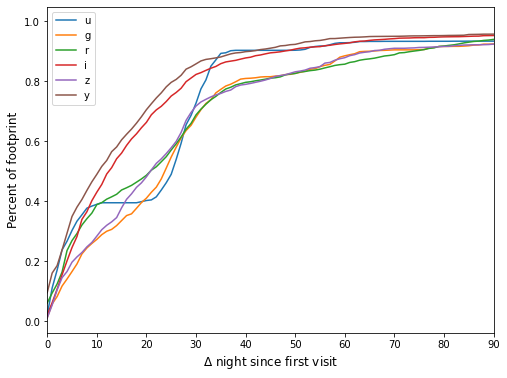

In [16]:

plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    # Show percent of footprint 
    plt.plot(nights[:-1], area_since_first[f] / footprint_area[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlim(0, 90)
plt.xlabel(r'$\Delta$ night since first visit', fontsize='large')
#plt.ylabel('Area with possible template', fontsize='large')
plt.ylabel('Percent of footprint', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
print(footprint_area)

In [17]:
# To do: make this figure for each filter, where the different lines are the different cadence simulations

# Remove visits without templates using Peter's code

Add Lynne's requirements on image quality when counting number of available images to generate template with.

Peter's code assumes that a template will be generated once, on a given night.

In [18]:
# new base class. We might consider moving this into BaseMetric, or maybe doing this in the slicer instead.
class BaseTemplateMetric(maf.metrics.BaseMetric):
    """Make a new base class that will filter out observation from before we have templates available
    """
    def __init__(self,
                col=None,
                n_visits_for_template=3., # note that this is float
                night_template_min=182,
                mjdCol='observationStartMJD',
                nightCol='night',
                filterCol='filter',
                 seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 **kwargs):
        if col is None:
            col = []
        else:
            col = [col]
        col += [mjdCol, nightCol, filterCol]
        super().__init__(col=col, **kwargs)
        self.n_visits_for_template = n_visits_for_template
        self.night_template_min = night_template_min
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol
        
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        
#         print(self.seeing_ratio,self.m5_range)
        
    def _remove_no_template_visits(self, dataSlice):
        
        dataSlice.sort(order=self.mjdCol)
        
        # add Lynne's seeing requirements
        # Find the best seeing in the first few images
        n_visits = int(self.n_visits_for_template) # number of good images required for template
        bench_seeing = np.min(dataSlice[self.seeingCol][0:n_visits+1])
        bench_m5 = np.max(dataSlice[self.m5Col][0:n_visits+1])
        
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False)
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)
        
        # template images must have been taken before the generation date
        template_time = np.where(dataSlice[self.nightCol] < self.night_template_min,
                        True, False)
        # science images can only be counted after the generation date
        image_time = np.where(dataSlice[self.nightCol] > self.night_template_min,
                        True, False)
        # should use a greater than sign for nights here? Or allow leeway for template generation time?
        
        # use masks to remove images not suitable for templates/science
        # everything starts as true and is switched to false if required
        has_template_indx = np.ones(dataSlice.size, dtype=bool)
        template_img_indx = np.ones(dataSlice.size, dtype=bool)
        # define list of images that are suitable for generating templates
        template_img_indx[~(seeing_ok & m5_ok & template_time)] = False
        
        # define list of possible science images, can't have a template before the template construction time
        has_template_indx[~(image_time)] = False
        
#         print(self.night_template_min,len(dataSlice),sum(template_img_indx),sum(has_template_indx))
        
        # look at each dataslice by filter, template images must be in the same filter
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)[0]
            
            # check if there are is a sufficent number of template images
            # if not, no science images can be counted until next template time
            if sum(template_img_indx[infilt])<n_visits:
                has_template_indx[infilt] = False
        
#         print(sum(has_template_indx))

        return dataSlice[has_template_indx]
        
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return

In [19]:

# OK, now let's write a function that takes a bunch of observations in, 
# then cuts out ones that probably don't have template images

# Class that will return all the id's that we think have templates generated
class HasTemplateIndx(BaseTemplateMetric):
    """Return the obIds that probably have templates
    """
    def __init__(self, col='observationId', metricDtype="object", **kwargs):
        super().__init__(col=col, metricDtype=metricDtype, **kwargs)
        self.idCol = col
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return dataSlice[self.idCol]

In [20]:

def remove_no_templates(data_in, nside=32, id_col='observationId', night_template_min = 182, **kwargs):
    """Remove visits that probably have no templates
    """
    slicer = maf.slicers.HealpixSlicer(nside=nside, verbose=False)
    metric = HasTemplateIndx(night_template_min = night_template_min, **kwargs)
    print("night_template_min = {}".format(metric.night_template_min))
    sql=None
    bundle = maf.MetricBundle(metric, slicer, sql)
    mbg = maf.MetricBundleGroup([bundle], None, saveEarly=False,
                                verbose=False)
    mbg.runCurrent(None, simData=data_in)
    all_vals = np.concatenate(bundle.metricValues.data[~bundle.metricValues.mask])
    valid_ids = np.unique(all_vals)
    indx = np.in1d(data_in[id_col], valid_ids)
    result = data_in[indx]
    return result

In [21]:
night_template_min = 1
x = HasTemplateIndx(night_template_min=1)
x.__dict__.keys()

dict_keys(['colNameArr', 'maps', 'badval', 'name', 'reduceFuncs', 'reduceOrder', 'metricDtype', 'units', 'comment', 'shape', 'n_visits_for_template', 'night_template_min', 'mjdCol', 'nightCol', 'filterCol', 'seeingCol', 'm5Col', 'seeing_ratio', 'm5_range', 'idCol'])

In [22]:
x.night_template_min, x.mjdCol

(1, 'observationStartMJD')

In [23]:
opsdb

'first_year_baseline_v3.0_10yrs.db'

In [24]:
# let's load up some data for year 1 of observations
data = maf.getSimData(opsdb, None, None, full_sql_query='select * from observations where night < 365;')

In [25]:
pd.DataFrame(data)[['seeingFwhmEff','fiveSigmaDepth']]

,seeingFwhmEff,fiveSigmaDepth
0,0.694106,22.546480
1,0.699498,22.532127
2,0.694568,22.546281
3,2.363392,23.128326
4,2.418207,23.075882
...,...,...
216115,1.465921,22.575541
216116,1.459859,22.589142
216117,1.507974,22.458614
216118,1.516937,22.447880


In [26]:
# set limits high, should get same results as Peter's default notebook
# where there was no quality control on template images
data_w_templates = remove_no_templates(data,seeing_ratio=200., m5_range=5)
data_w_templates.size

night_template_min = 182


68823

In [27]:
# set template generation night to zero, nothing should get through
data_w_templates = remove_no_templates(data,seeing_ratio=200., m5_range=5,night_template_min = 0.)
data_w_templates.size

night_template_min = 0.0


0

In [28]:
# use lynne's limits for good seeing
# there should be fewer templates generated
data_w_templates = remove_no_templates(data)
data_w_templates.size

night_template_min = 182


55297

In [29]:
# set limits really low to test that no templates get made
data_w_templates = remove_no_templates(data,seeing_ratio=0., m5_range=0.0,)
data_w_templates.size

night_template_min = 182


0

# time the remove_no_templates function

In [30]:
# for a fixed template creation time, see how code scales with nside

nside_test_fname = "df_nside_test.csv"

if os.path.isfile(nside_test_fname):
    print("load {}".format(nside_test_fname))
    df_nside_test = pd.read_csv(nside_test_fname, index_col = 0)
    
else:
    nside_list = [32,64,128,256]
    dt_list = []
    data_size = []

    for nside in nside_list:

        start = time.time()
        data_w_templates = remove_no_templates(data,nside = nside)
        end = time.time()
        dt = end-start
        n=data_w_templates.size

        dt_list.append(dt)
        data_size.append(n)

        print(nside,dt,n)
        
    df_nside_test = pd.DataFrame({"nside":nside_list,
    "dt(s)":dt_list,
    "n_visits":data_size})
    df_nside_test.to_csv(nside_test_fname)

load df_nside_test.csv


In [31]:
df_nside_test

,nside,dt(s),n_visits
0,32,5.566162,55297
1,64,21.621621,65264
2,128,88.841348,69754
3,256,381.948361,72377


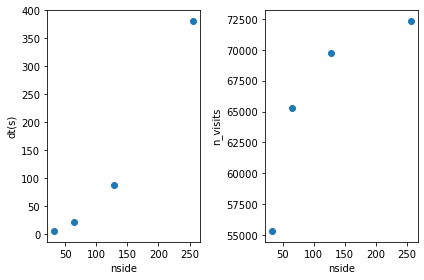

In [32]:
# plot the increase in runtime with n_side
# also the change in counts of visits as nside changes - should reach a maximum as resolution increases
# as healpix size is reduced, the generation of partial templates means more visits can be used

x_plot = "nside"
y_plot1 = "dt(s)"
y_plot2 = "n_visits"
df_plot = df_nside_test

fig = plt.figure()
gs = gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

ax1.scatter(df_plot[x_plot],df_plot[y_plot1])
ax2.scatter(df_plot[x_plot],df_plot[y_plot2])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot1)
ax2.set_xlabel(x_plot)
ax2.set_ylabel(y_plot2)

plt.tight_layout()

plt.show()

NEED TO DIVIDE data INTO CHUNKS OF THE CORRECT TIMESCALE (template_timescale).

If Peter's code considers template generation on a single night, we can pass visits to it in growing chunks based on the dates when we want to consider template generation.

Pass all visits with night <= t + template_timescale so that all previous observations will count towards making templates

In [33]:
# Make runtime estimates for a range of template timescales
nside_list = [32,64,128,256]

# tscales = [1,7,14,28,28*2,28*3,28*4,28*6]
tscales = [28,28*4,28*6]
# tscales = [28*4]

for _nside in nside_list:
    dt = df_nside_test[df_nside_test["nside"]==_nside].iloc[0]["dt(s)"]

    print("nside = {}, dt(1 step) = {} s".format(_nside,dt))

    t_tot = 0
    for template_timescale in tscales:

        template_nights = np.arange(template_timescale,365+template_timescale,template_timescale)
        template_nights[-1] = 365 # consider only the first year

        t_est = dt * len(template_nights)
        t_tot += t_est
        print(template_timescale,len(template_nights),t_est/60/60) # print time estimate in hours for each template timescale

    print("t_tot = {:.2f} min ({:2f} hrs)".format(t_tot/60,t_tot/60/60))


nside = 32, dt(1 step) = 5.566162109375 s
28 14 0.021646185980902777
112 4 0.006184624565972223
168 3 0.004638468424479167
t_tot = 1.95 min (0.032469 hrs)
nside = 64, dt(1 step) = 21.621620893478397 s
28 14 0.08408408125241598
112 4 0.024024023214975997
168 3 0.018018017411231997
t_tot = 7.57 min (0.126126 hrs)
nside = 128, dt(1 step) = 88.84134769439697 s
28 14 0.34549412992265494
112 4 0.09871260854932996
168 3 0.07403445641199748
t_tot = 31.09 min (0.518241 hrs)
nside = 256, dt(1 step) = 381.9483609199524 s
28 14 1.485354736910926
112 4 0.424387067688836
168 3 0.318290300766627
t_tot = 133.68 min (2.228032 hrs)


# Run the full remove template code on all date ranges

In [34]:
start = time.time()

# nside = 32
nside = 256

print(opsdb,nside)

templates_fname = "{}_{}_{}.json".format(opsdb.split(".db")[0],nside,"-".join(str(x) for x in tscales))

if os.path.isfile(templates_fname):
    print("load {}".format(templates_fname))
    template_visits = json.load( open(templates_fname) )
else:
    template_visits = {}
    for template_timescale in tscales:

        n_visits = []
        obsIds = []

        # divide year 1 into chunks of a given template_timescale
        template_nights = np.arange(0,365+template_timescale,template_timescale)
        template_nights[-1] = 365 # consider only the first year

        for i in range(1,len(template_nights)):
            t_data = template_nights[i] # query all visits up to the time when we must consider new template generation
            t_template = template_nights[i-1] # this is the last date at which templates were generated
            # select visits in chunk from original year 1 database
            data = maf.getSimData(opsdb, None, None,
                                  full_sql_query='select * from observations where night <= {};'.format(t_data))
            # remove templates without visits
            data_w_templates = remove_no_templates(data, night_template_min = t_template, nside = nside)
            n = data_w_templates.size
            n_visits.append(n)
            obsIds += list(data_w_templates["observationId"])
            print(t,n,data.size,len(obsIds))

        # get the ids of each observation that has a template and can be kept
        # store the obsids of each timescale
        template_visits[str(template_timescale)] = {"n_visits":np.array(n_visits).tolist(),
                                              "template_nights":np.array(template_nights[1:]).tolist(),
                                              "obsIds":np.array(obsIds).tolist()}
    #     break

    end = time.time()
    dt = end-start
    print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

    json.dump( template_visits, open(templates_fname, 'w' ) )

first_year_baseline_v3.0_10yrs.db 256
load first_year_baseline_v3.0_10yrs_256_28-112-168.json


In [35]:
template_visits.keys()

dict_keys(['28', '112', '168'])

In [36]:
# save the redacted database for each timescale
df_data = pd.DataFrame(data)
print(len(df_data))

for template_timescale in tscales:
    
    df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(template_timescale)]["obsIds"])]
    print(template_timescale, len(df_data_w_templates))
    
    fname = "visit_cut_t-{}d_nside-{}.db".format(template_timescale,nside)
    print(fname)

    # open up a connection to a new database
    conn = sqlite3.connect(fname)
    # save reduced visit dataframe to sql
    df_data_w_templates.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()

216120
28 155018
visit_cut_t-28d_nside-256.db
112 99033
visit_cut_t-112d_nside-256.db
168 76901
visit_cut_t-168d_nside-256.db


In [37]:
# select a timescale to analyse
template_timescale = 28
df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(template_timescale)]["obsIds"])]

In [38]:
sys.getsizeof(df_data_w_templates)

72894178

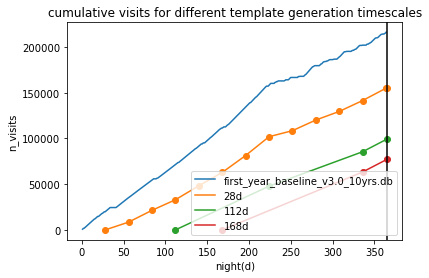

In [39]:
# plot the (cumulative) number of visits with templates as a function of survey night
# different lines show the effect of generating templates on different timescales

x_plot = "night(d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# plot year 1 baseline
nights = np.arange(0, 365, 1)
counts, bins = np.histogram(df_year1["night"], bins=nights)
ax1.plot(bins[1:], counts.cumsum(), label = year1_fname)
# ax1.axhline(len(df_year1))

# plot each template generation timescale
for i,t in enumerate(tscales):
#     ax1.plot(template_visits[str(t)]["template_nights"], template_visits[str(t)]["n_visits"], label = "{}d".format(t))
#     ax1.scatter(template_visits[str(t)]["template_nights"], template_visits[str(t)]["n_visits"])
    ax1.plot(template_visits[str(t)]["template_nights"], np.array(template_visits[str(t)]["n_visits"]).cumsum(),
             label = "{}d".format(t),c="C{}".format(i+1))
    ax1.scatter(template_visits[str(t)]["template_nights"], np.array(template_visits[str(t)]["n_visits"]).cumsum(),
               c="C{}".format(i+1))

ax1.legend()
ax1.axvline(365,c="k")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.title("cumulative visits for different template generation timescales")

plt.show()

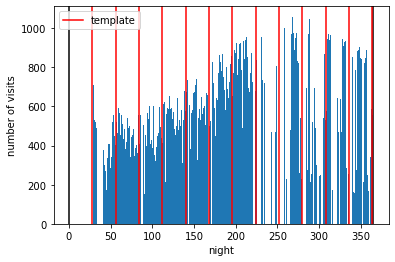

In [40]:
# distribution of visits with templates by night

x_plot = "night"
df_plot = df_data_w_templates
bins = np.arange(0,366,1)

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.hist(df_plot[x_plot],bins=bins)

ax1.axvline(0,c="k")
ax1.axvline(365,c="k")

for t in np.arange(template_timescale,365+template_timescale,template_timescale):
    if t>365:
        continue
    ax1.axvline(t,c="r", label = "template")

ax1.set_xlabel(x_plot)
ax1.set_ylabel("number of visits")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

plt.show()

In [41]:
for t in tscales:
    print(t, template_visits[str(t)]["n_visits"][-1])

28 258
112 13775
168 13775


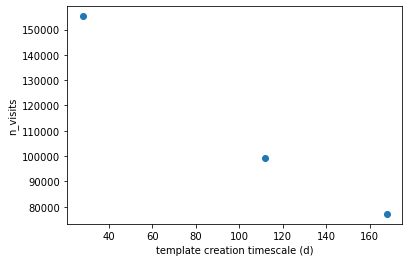

In [42]:
# plot number of visits vs template timescale
    
x_plot = "template creation timescale (d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(tscales, [np.array(template_visits[str(t)]["n_visits"]).cumsum()[-1] for t in tscales])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()